### Modeling and visualizing dynamics of COVID cases in Maryland counties
#### Anna Konstorum (konstorum.anna@gmail.com)

In [1]:
# import packages
import datetime
import os
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import seaborn as sns
import pandas as pd
import numpy as np
import seaborn as sns
import html5lib
from matplotlib.lines import Line2D
import urllib.request, json 
import datetime as dt
from pandas.io.json import json_normalize

%matplotlib inline

In [2]:
print(f'Last updated: {datetime.date.today()}')

Last updated: 2020-09-07


In [3]:
# Change to local directory to save files
os.chdir('/Users/annakonstorum/Google Drive/Covid_model_v2/results')

#### USER DEFINED FUNCTIONS

In [4]:
def url_to_df(url_in):
    '''
    Converts json files from url to dataframes
    Renames and removes select columns
    Indexes by date
    Inpute data: url_in
    Output data: df_out
    '''
    
    with urllib.request.urlopen(url_in) as url:
        data = json.loads(url.read().decode())
        df_out=json_normalize(data['features'])
        col_names = [item.split('.')[1] for item in df_out.columns]
        df_out.columns=col_names
        if url_in == url_negative:
            df_out['Date']=pd.to_datetime(df_out.ReportDate, unit='ms').dt.date
            df_out.drop(['OBJECTID','ReportDate'],axis=1,inplace=True) 
        else:
            df_out['Date']=pd.to_datetime(df_out.DATE, unit='ms').dt.date
            df_out.drop(['OBJECTID','DATE'],axis=1,inplace=True) 
        df_out.index=df_out['Date']
        df_out.drop(['Date'],axis=1,inplace=True) 
    return df_out

# exponential, quadratic, and linear functions for predictive modeling
def exp_func(x, a, b, c):
    ''' 
    Exponential gunction a*e^{b*x}+c 
    Input data (x) and parameters (a,b,c)
    '''
    return a * np.exp(b * x) + c

def quad_func(x,a,b,c):
    ''' 
    Quadratic gunction a*x^{2}+b*x+c
    Input data (x) and parameters (a,b,c)
    '''
    return a*x**2 +b*x+c

def lin_func(x,a,b):
    '''
    Linear function a*x+b
    Input data (x) and parameters (a,b)
    '''
    return a*x + b

def SSE_curve(x,y,fxn):
    '''
    Fit data (x and y vectors) using input function (fxn)
    Calculate sum of squared errors (SSE)
    '''
    popt,pop = curve_fit(fxn,x,y)
    y_exp= fxn(x, *popt)
    SSE = sum((y-y_exp)**2)
    return popt,SSE

def function_use(county,model_results):
    '''
    Input model results for particular county
    Output which function to use and the model type
    '''
    if model_results.loc[county]["model"]=='exp':
        func_use=exp_func
        opt_model = 'Exponential'
    elif model_results.loc[county]["model"]=='quad':
        func_use=quad_func
        opt_model = 'Quadratic (up)'
        if model_results.loc[county]['a']<0:
            opt_model = "Quadratic (down)"
    else:
        func_use=lin_func
        opt_model = 'Linear'
    return func_use, opt_model

#### Data ETL

In [5]:
# Get data from Maryland DPH
url_total_cases='https://services.arcgis.com/njFNhDsUCentVYJW/arcgis/rest/services/MDCOVID19_TotalCasesStatewide/FeatureServer/0/query?where=1%3D1&outFields=*&outSR=4326&f=json'
url_total_deaths='https://services.arcgis.com/njFNhDsUCentVYJW/arcgis/rest/services/MDCOVID19_TotalConfirmedDeathsStatewide/FeatureServer/0/query?where=1%3D1&outFields=*&outSR=4326&f=json'
url_hosp = 'https://services.arcgis.com/njFNhDsUCentVYJW/arcgis/rest/services/MDCOVID19_TotalHospitalizations/FeatureServer/0/query?where=1%3D1&outFields=*&outSR=4326&f=json'
url_gender_cases='https://services.arcgis.com/njFNhDsUCentVYJW/arcgis/rest/services/MDCOVID19_CasesByGenderDistribution/FeatureServer/0/query?where=1%3D1&outFields=*&outSR=4326&f=json'
url_gender_deaths='https://services.arcgis.com/njFNhDsUCentVYJW/arcgis/rest/services/MDCOVID19_ConfirmedDeathsByGenderDistribution/FeatureServer/0/query?where=1%3D1&outFields=*&outSR=4326&f=json'
url_county_cases = 'https://services.arcgis.com/njFNhDsUCentVYJW/arcgis/rest/services/MDCOVID19_CasesByCounty/FeatureServer/0/query?where=1%3D1&outFields=*&outSR=4326&f=json'
url_county_deaths = 'https://services.arcgis.com/njFNhDsUCentVYJW/arcgis/rest/services/MDCOVID19_ConfirmedDeathsByCounty/FeatureServer/0/query?where=1%3D1&outFields=*&outSR=4326&f=json'
url_ethnic_cases='https://services.arcgis.com/njFNhDsUCentVYJW/arcgis/rest/services/MDCOVID19_CasesByRaceAndEthnicityDistribution/FeatureServer/0/query?where=1%3D1&outFields=*&outSR=4326&f=json'
url_ethnic_deaths='https://services.arcgis.com/njFNhDsUCentVYJW/arcgis/rest/services/MDCOVID19_ConfirmedDeathsByRaceAndEthnicityDistribution/FeatureServer/0/query?where=1%3D1&outFields=*&outSR=4326&f=json'
url_age_cases='https://services.arcgis.com/njFNhDsUCentVYJW/arcgis/rest/services/MDCOVID19_CasesByAgeDistribution/FeatureServer/0/query?where=1%3D1&outFields=*&outSR=4326&f=json'
url_age_deaths='https://services.arcgis.com/njFNhDsUCentVYJW/arcgis/rest/services/MDCOVID19_ConfirmedDeathsByAgeDistribution/FeatureServer/0/query?where=1%3D1&outFields=*&outSR=4326&f=json'
url_negative = 'https://services.arcgis.com/njFNhDsUCentVYJW/arcgis/rest/services/MDCOVID19_NumberOfPersonsTestedNegative/FeatureServer/0/query?where=1%3D1&outFields=*&outSR=4326&f=json'

In [6]:
# Import demographic data from census.gov
# maryland population demographics
url='https://raw.githubusercontent.com/akonstodata/md_county_covid/master/data/MD_2019_pop.csv'
md_pop=pd.read_csv(url,sep=',',header='infer',index_col=0)

In [7]:
# create dataframes from input json files
df_t_c=url_to_df(url_total_cases)
df_t_c.columns=['total_cases']
df_c_c=url_to_df(url_county_cases)
df_t_d=url_to_df(url_total_deaths)
df_t_d.columns=['total_deaths']
df_g_c=url_to_df(url_gender_cases)
df_g_d=url_to_df(url_gender_deaths)
df_c_d=url_to_df(url_county_deaths)
df_h=url_to_df(url_hosp)
df_h.columns=['total_hosp']
df_e_c=url_to_df(url_ethnic_cases)
df_e_d=url_to_df(url_ethnic_deaths)
df_n = url_to_df(url_negative)
df_a_c = url_to_df(url_age_cases)
df_a_d = url_to_df(url_age_deaths)

In [8]:
# join certain dataframes for downstream analysis
df_e_c2=df_e_c.join(df_t_c,how='inner')
df_e_d2=df_e_d.join(df_t_d,how='inner')

df_g_c2=df_g_c.join(df_t_c,how='inner')
df_g_d2=df_g_d.join(df_t_d,how='inner')

df_h_t=df_h.join(df_t_c,how='outer')
df_h_t_d=df_h_t.join(df_t_d,how='outer')
df_h_t_d=df_h_t_d.join(df_n,how='outer')
df_h_t_d.fillna(0,inplace=True)

df_c_c2=df_c_c.join(df_t_c,how='inner')
df_c_d2=df_c_d.join(df_t_d,how='inner')
df_c_c3=df_c_c2.join(df_h,how='outer')
df_c_c3=df_c_c3.join(df_n,how='outer')
df_c_c3.fillna(0,inplace=True)

In [9]:
# get data date range
start_date = min(df_h_t_d.index)
end_date = max(df_h_t_d.index)
next_date=end_date+datetime.timedelta(days=1)

print(f'Data from {start_date.strftime("%Y-%m-%d")} to {end_date.strftime("%Y-%m-%d")}')

Data from 2020-03-04 to 2020-09-07


In [10]:
# Textual date for labels
tomorrow_label = (end_date + datetime.timedelta(days=1)).strftime('%m/%d')
next2_label = (end_date + datetime.timedelta(days=2)).strftime('%m/%d')
next3_label = (end_date + datetime.timedelta(days=3)).strftime('%m/%d')

# get current date range
date_range=pd.date_range(start=start_date, end=end_date)

# output date range as list
dates = [date.strftime('%m/%d') for date in date_range]

### Create predictive models for the data

In [11]:
# historical model fit for total and select counties and hosp
import math

counties_to_model=['Anne_Arundel','Baltimore','Baltimore_City','Prince_Georges','Montgomery','Howard','total_cases','total_hosp']
model_results_hist=pd.DataFrame(index=range(10,df_c_c3.shape[0]),columns=counties_to_model)
model_results_hist.fillna(0)

for i in range(10,df_c_c3.shape[0]):
    xdata=np.array(range(i-9,i+1))
    for county in counties_to_model:
        ydata=np.array(df_c_c3[county].iloc[range(i-9,i+1)])
        popt_quad,SSE_quad = SSE_curve(xdata,ydata,quad_func)
        popt_lin,SSE_lin = SSE_curve(xdata,ydata,lin_func)

        quad_lin_diff=((SSE_lin/SSE_quad)-1)*100

        if quad_lin_diff<5:
            no_quad=1
        else:
            no_quad=0

        try:
            popt_exp, SSE_exp = SSE_curve(xdata,ydata,exp_func)
            min_error=min(SSE_exp,SSE_quad,SSE_lin)
        except:    
            min_error=min(SSE_quad,SSE_lin)

        if (min_error==SSE_quad) and (no_quad==1):
            min_error=SSE_lin

        if min_error == SSE_quad:
            if popt_quad[0]>0:
                model_type = "Quadratic(up)"
                color='orange'
            else:
                model_type = "Quadratic(down)"
                color='green'
            output=color
        elif min_error == SSE_lin:
            output="green"
        elif min_error == SSE_exp:
            output="red"
        model_results_hist.loc[i,county]=output

/Users/annakonstorum/anaconda/lib/python3.6/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


In [12]:
# model fit for select counties
import math

counties_to_model=['Anne_Arundel','Baltimore','Baltimore_City','Prince_Georges','Montgomery','Howard','total_cases','total_hosp']
model_results=pd.DataFrame(index=counties_to_model,columns=['a','b','c','model'])
model_results.fillna(0)

len_data = df_c_c3.shape[0]
xdata=np.array(range(len_data-9,len_data+1))
for county in counties_to_model:
    ydata=np.array(df_c_c3[county].iloc[-10:])
    popt_quad,SSE_quad = SSE_curve(xdata,ydata,quad_func)
    popt_lin,SSE_lin = SSE_curve(xdata,ydata,lin_func)
    
    quad_lin_diff=((SSE_lin/SSE_quad)-1)*100
    if quad_lin_diff<5:
        no_quad=1
    else:
        no_quad=0
    
    try:
        popt_exp, SSE_exp = SSE_curve(xdata,ydata,exp_func)
        min_error=min(SSE_exp,SSE_quad,SSE_lin)
    except:    
        min_error=min(SSE_quad,SSE_lin)
    
    if (min_error==SSE_quad) and (no_quad==1):
        min_error=SSE_lin

    if min_error == SSE_quad:
        model_results.loc[county,['a','b','c']]=popt_quad
        model_results.loc[county,'model']='quad'
    elif min_error == SSE_lin:
        model_results.loc[county,['a','b']]=popt_lin
        model_results.loc[county,'model']='lin'
    elif min_error == SSE_exp:
        model_results.loc[county,['a','b','c']]=popt_exp
        model_results.loc[county,'model']='exp'

/Users/annakonstorum/anaconda/lib/python3.6/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


### Maryland model and dynamics

In [13]:
next_day=df_c_c3.shape[0]+1; next2_day=next_day+1;next3_day=next2_day+1

In [14]:
# Use statistical model for state cases and hospitalizations to make predictions for next three days

popt_state = model_results.loc["total_cases"][0:3]
func_use, opt_model = function_use("total_cases",model_results)

popt_hosp = model_results.loc["total_hosp"][0:3]
func_use_hosp, opt_model_hosp = function_use("total_hosp",model_results)

if opt_model=="Linear":
    next_day_cases = func_use(next_day, popt_state[0], popt_state[1])
    next2_day_cases = func_use(next2_day, popt_state[0], popt_state[1])
    next3_day_cases = func_use(next3_day, popt_state[0], popt_state[1])

else:    
    next_day_cases = func_use(next_day, popt_state[0], popt_state[1], popt_state[2])
    next2_day_cases = func_use(next2_day, popt_state[0], popt_state[1], popt_state[2])
    next3_day_cases = func_use(next3_day, popt_state[0], popt_state[1], popt_state[2])

if opt_model_hosp=="Linear":
    next_day_cases_hosp = func_use_hosp(next_day, popt_hosp[0], popt_hosp[1])
    next2_day_cases_hosp = func_use_hosp(next2_day, popt_hosp[0], popt_hosp[1])
    next3_day_cases_hosp = func_use_hosp(next3_day, popt_hosp[0], popt_hosp[1])

else:
    next_day_cases_hosp = func_use_hosp(next_day, popt_hosp[0], popt_hosp[1], popt_hosp[2])
    next2_day_cases_hosp = func_use_hosp(next2_day, popt_hosp[0], popt_hosp[1], popt_hosp[2])
    next3_day_cases_hosp = func_use_hosp(next3_day, popt_hosp[0], popt_hosp[1], popt_hosp[2])


loc = "Maryland cases"
locH = "Maryland hospitalizations"
model = "Best fit model: {}"
pred_text="Prediction for total cases:"
next_pred='\t{}: {}';

### Plot total Maryland cases and hospitalizations, along with predictions

/Users/annakonstorum/anaconda/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/annakonstorum/anaconda/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)


<Figure size 576x360 with 0 Axes>

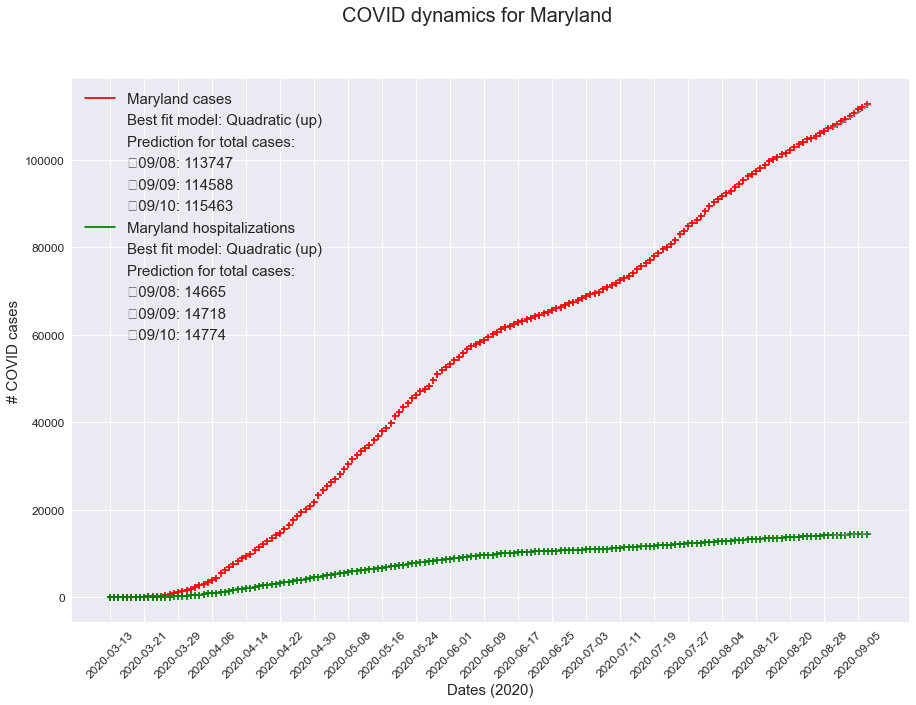

In [16]:
fig = plt.figure(figsize=(8,5))

legend_elements =  [Line2D([0], [0], marker='+', color='red', label=loc, markersize=15),
                    Line2D([0], [0], marker='', color='black',linestyle='', label=model.format(opt_model), markersize=15),
                Line2D([1], [0], marker='', color='black',linestyle='', label=pred_text, markersize=1),
                   Line2D([1], [0], marker='', color='black',linestyle='', label=next_pred.format(tomorrow_label,int(next_day_cases)), markersize=1),
                   Line2D([0], [0], marker='', color='black',linestyle='', label=next_pred.format(next2_label,int(next2_day_cases)), markersize=15),
                   Line2D([0], [0], marker='', color='black',linestyle='', label=next_pred.format(next3_label,int(next3_day_cases)), markersize=15),
                    Line2D([0], [0], marker='+', color='green', label=locH, markersize=15),
                    Line2D([0], [0], marker='', color='black',linestyle='', label=model.format(opt_model_hosp), markersize=15),
                Line2D([1], [0], marker='', color='black',linestyle='', label=pred_text, markersize=1),
                   Line2D([1], [0], marker='', color='black',linestyle='', label=next_pred.format(tomorrow_label,int(next_day_cases_hosp)), markersize=1),
                   Line2D([0], [0], marker='', color='black',linestyle='', label=next_pred.format(next2_label,int(next2_day_cases_hosp)), markersize=15),
                   Line2D([0], [0], marker='', color='black',linestyle='', label=next_pred.format(next3_label,int(next3_day_cases_hosp)), markersize=15)]

plt.figure(figsize=(15,10))

if opt_model=='Linear':
    popt_state=popt_state[0:2]
if opt_model_hosp=="Linear":
    popt_hosp=popt_hosp[0:2]

len_data = df_c_c3.shape[0]
xdata_pred=np.array(range(len_data-9,len_data+1))
xdata=np.array(range(0,df_c_c3.shape[0]))

plt.plot(xdata_pred, func_use(xdata_pred, *popt_state), color='grey',linestyle='--');
plt.scatter(xdata,df_c_c3['total_cases'],color='red',marker='+');

plt.plot(xdata_pred, func_use_hosp(xdata_pred, *popt_hosp), color='grey',linestyle='--');
plt.scatter(xdata,df_c_c3['total_hosp'],color='green',marker='+');

#plt.vlines(x=0, ymin=0, ymax=50,color='dimgrey', linewidth=0.5,linestyle='-.');
#plt.text(0.4,40,"[1]",rotation=0,color='black',fontsize = 13,verticalalignment='center',horizontalalignment='center');

#plt.vlines(x=11, ymin=0, ymax=100,color='dimgrey', linewidth=0.5,linestyle='-.');
#plt.text(11.4,90,"[2]",rotation=0,color='black',fontsize = 13,verticalalignment='center',horizontalalignment='center');

#plt.vlines(x=18, ymin=0, ymax=370,color='dimgrey', linewidth=0.5,linestyle='-.');
#plt.text(18.4,360,"[3]",rotation=0,color='black',fontsize = 13,verticalalignment='center',horizontalalignment='center');

#plt.vlines(x=25, ymin=0, ymax=1750,color='dimgrey', linewidth=0.5,linestyle='-.');
#plt.text(25.5,1740,"[4]",rotation=0,color='black',fontsize = 13,verticalalignment='center',horizontalalignment='center');

plt.ylabel('# COVID cases',fontsize=15);
frequency=8;
plt.xticks(xdata[:-1:frequency],df_c_c3.index[:-1:frequency],rotation=45,fontsize=12);
plt.yticks(fontsize=12)
plt.xlabel('Dates (2020)',fontsize=15)
plt.legend(handles=legend_elements,fontsize=15,loc='upper left')
plt.suptitle("COVID dynamics for Maryland",fontsize=20);
#plt.title(sub, fontsize=13);
plt.savefig("MD_COVID_model.png")

### Plot history of model type for total cases and hospitalizations:
Each color represents the model type generated from the previous ten days of data
1. Green == quadratic (down) or linear
2. Orange == quadratic (up)
3. Red == exponential

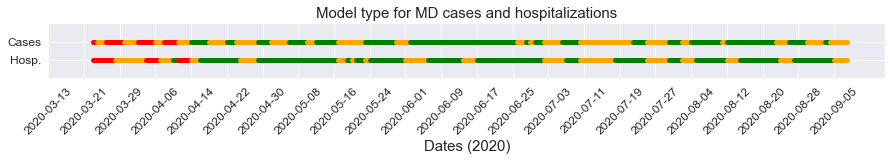

In [19]:
plt.figure(figsize=(15,1))

for date_index in model_results_hist.index:
    color_t=model_results_hist.loc[date_index,"total_cases"]
    plt.plot([date_index,date_index+1],[2,2],color=color_t,linewidth=5.0)
    color_h=model_results_hist.loc[date_index,"total_hosp"]
    plt.plot([date_index,date_index+1],[1,1],color=color_h,linewidth=5.0)
    plt.ylim([0,3])
    
frequency=8;
plt.xticks(xdata[:-1:frequency],df_c_c3.index[:-1:frequency],rotation=45,fontsize=12);
plt.yticks(fontsize=12)
plt.yticks(ticks=np.arange(1,3),labels=['Hosp.', 'Cases'])
plt.xlabel('Dates (2020)',fontsize=15)
plt.title('Model type for MD cases and hospitalizations',fontsize=15)

### Analysis of MD ethnic/race and age COVID19 Statistics

In [85]:
# Calculate cumulative cases/100,000 of population for each race
df_e_c2['African_American_f']=round((df_e_c2['African_American']*100000)/md_pop.loc['African-American (NH)']['Population_2019'],0)
df_e_c2['Asian_f']=round((df_e_c2['Asian']*100000)/md_pop.loc['Asian (NH)']['Population_2019'],0)
df_e_c2['Hispanic_f']=round((df_e_c2['Hispanic']*100000)/md_pop.loc['Hispanic']['Population_2019'],0)
df_e_c2['White_f']=round((df_e_c2['White']*100000)/md_pop.loc['White (NH)']['Population_2019'],0)
df_e_c2['Total_f']=round((df_e_c2['total_cases']*100000)/md_pop.loc['Total']['Population_2019'],0)
df_e_c2_f=df_e_c2[['African_American_f','Asian_f','Hispanic_f','White_f','Total_f']]

In [86]:
# Calculate CFR for different races/ethnicities
df_e_cfr=pd.DataFrame(index=df_e_d2.index, columns=['African_American','Asian','Hispanic','White','Total'])
df_e_cfr['African_American'] = round(df_e_d2['African_American']/df_e_c2['African_American'],4)
df_e_cfr['Asian'] = round(df_e_d2['Asian']/df_e_c2['Asian'],4)
df_e_cfr['Hispanic'] = round(df_e_d2['Hispanic']/df_e_c2['Hispanic'],4)
df_e_cfr['White'] = round(df_e_d2['White']/df_e_c2['White'],4)
df_e_cfr['Total'] = round(df_e_d2['total_deaths']/df_e_c2['total_cases'],4)

In [87]:
# Calculate CFR for different ages
df_a_cfr=pd.DataFrame(index=df_a_d_2.index, columns=df_a_d_2.columns)
df_a_c_2_crop = df_a_c_2.iloc[10,:]
df_a_cfr['Age_0_to_9'] = round(df_a_d_2['Age_0_to_9']/df_a_c_2_crop['Age_0_to_9'],4)
df_a_cfr['Age_10_to_19'] = round(df_a_d_2['Age_10_to_19']/df_a_c_2_crop['Age_10_to_19'],4)
df_a_cfr['Age_20_to_29'] = round(df_a_d_2['Age_20_to_29']/df_a_c_2_crop['Age_20_to_29'],4)
df_a_cfr['Age_30_to_39'] = round(df_a_d_2['Age_30_to_39']/df_a_c_2_crop['Age_30_to_39'],4)
df_a_cfr['Age_40_to_49'] = round(df_a_d_2['Age_40_to_49']/df_a_c_2_crop['Age_40_to_49'],4)
df_a_cfr['Age_50_to_69'] = round(df_a_d_2['Age_50_to_69']/df_a_c_2_crop['Age_50_to_69'],4)
df_a_cfr['Age_70+'] = round(df_a_d_2['Age_70+']/df_a_c_2_crop['Age_70+'],4)

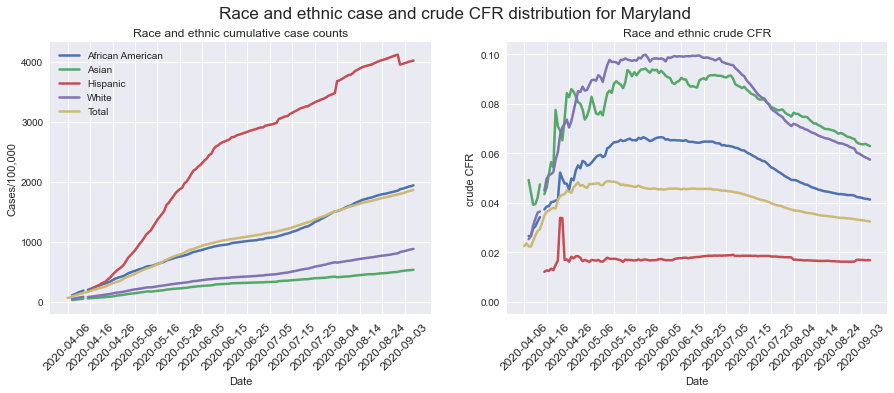

In [88]:
# Plot results of analysis for ethnicity/race statistics in MD

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
fig.suptitle('Race and ethnic case and crude CFR distribution for Maryland',fontsize=17)

ax0=df_e_c2_f.plot(linewidth=2.5,ax=axes[0])
ax0.legend(['African American','Asian','Hispanic','White','Total'])
ax0.set_ylabel('Cases/100,000')
ax0.set_xlabel('Date')
frequency=10
ax0.set_xticks(df_e_c.index[:-1:frequency])
ax0.set_xticklabels(df_e_c.index[:-1:frequency], rotation=45,fontsize=12)  
ax0.set_title('Race and ethnic cumulative case counts');

ax1=df_e_cfr.plot(linewidth=2.5,ax=axes[1])
#ax1.legend(['African American','Asian','Hispanic','White','Total'])
ax1.legend([])
ax1.set_ylabel('crude CFR')
ax1.set_xlabel('Date')
frequency=10
ax1.set_xticks(df_e_c.index[:-1:frequency])
ax1.set_xticklabels(df_e_c.index[:-1:frequency], rotation=45,fontsize=12) 
ax1.set_title('Race and ethnic crude CFR');       

In [98]:
df_a_c_2=df_a_c.copy()
df_a_c_2['Age_50_to_69'] = df_a_c_2['Age_50_to_59'] + df_a_c_2['Age_60_to_69']
df_a_c_2['Age_70+'] = df_a_c_2['Age_70_to_79'] + df_a_c_2['Age_80plus']
df_a_c_2.drop(['Age_70_to_79','Age_80plus','Age_50_to_59','Age_60_to_69', 'Age_Unknown'],1,inplace=True)
df_a_c_3=round((df_a_c_2.div(df_a_c_2.sum(axis=1), axis=0))*100,3)

In [90]:
df_a_d_2=df_a_d.copy()
df_a_d_2['Age_50_to_69'] = df_a_d_2['Age_50_to_59'] + df_a_d_2['Age_60_to_69']
df_a_d_2['Age_70+'] = df_a_d_2['Age_70_to_79'] + df_a_d_2['Age_80plus']
df_a_d_2.drop(['Age_70_to_79','Age_80plus','Age_50_to_59','Age_60_to_69', 'Age_Unknown'],1,inplace=True)

In [106]:
# Calculate CFR for different ages
df_a_cfr=pd.DataFrame(index=df_a_d_2.index, columns=df_a_d_2.columns)
df_a_c_2_crop = df_a_c_2.iloc[10,:]
df_a_cfr['Age_0_to_9'] = round(df_a_d_2['Age_0_to_9']/df_a_c_2_crop['Age_0_to_9'],4)
df_a_cfr['Age_10_to_19'] = round(df_a_d_2['Age_10_to_19']/df_a_c_2_crop['Age_10_to_19'],4)
df_a_cfr['Age_20_to_29'] = round(df_a_d_2['Age_20_to_29']/df_a_c_2_crop['Age_20_to_29'],4)
df_a_cfr['Age_30_to_39'] = round(df_a_d_2['Age_30_to_39']/df_a_c_2_crop['Age_30_to_39'],4)
df_a_cfr['Age_40_to_49'] = round(df_a_d_2['Age_40_to_49']/df_a_c_2_crop['Age_40_to_49'],4)
df_a_cfr['Age_50_to_69'] = round(df_a_d_2['Age_50_to_69']/df_a_c_2_crop['Age_50_to_69'],4)
df_a_cfr['Age_70+'] = round(df_a_d_2['Age_70+']/df_a_c_2_crop['Age_70+'],4)

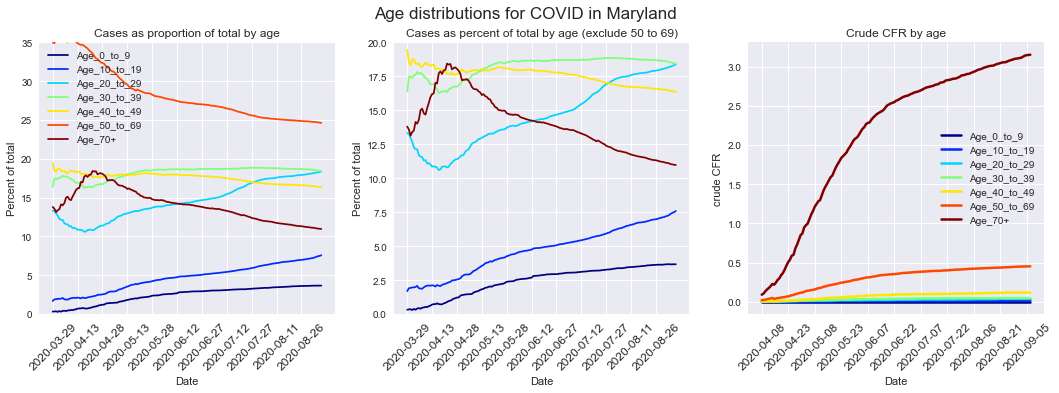

In [107]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18,5))
fig.suptitle('Age distributions for COVID in Maryland',fontsize=17)

col_to_plot=['Age_0_to_9','Age_10_to_19','Age_20_to_29','Age_30_to_39','Age_40_to_49','Age_50_to_69','Age_70+']
ax0=df_a_c_3.loc[:,col_to_plot].plot(ax = axes[0],colormap='jet')
ax0.set_xticklabels('')
ax0.set_xlabel('Date')
ax0.set_ylim([0,35])
frequency=15
ax0.set_xticks(df_a_c_3.index[:-1:frequency]);
ax0.set_xticklabels(df_a_c_3.index[:-1:frequency], rotation=45,fontsize=12);
ax0.set_ylabel('Percent of total')
#ax0.legend(loc='center right', bbox_to_anchor=(1.0, 0.5))
ax0.set_title('Cases as proportion of total by age')

col_to_plot=['Age_0_to_9','Age_10_to_19','Age_20_to_29','Age_30_to_39','Age_40_to_49','Age_50_to_69','Age_70+']
ax1=df_a_c_3.loc[:,col_to_plot].plot(ax = axes[1],colormap='jet')
ax1.set_ylim([0,20])
ax1.set_xticklabels('')
ax1.set_xlabel('Date')
#ax1.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
ax1.legend([])
ax1.set_ylabel('Percent of total')
frequency=15
ax1.set_xticks(df_a_c_3.index[:-1:frequency]);
ax1.set_title('Cases as percent of total by age (exclude 50 to 69)')
ax1.set_xticklabels(df_a_c_3.index[:-1:frequency], rotation=45,fontsize=12) ;

ax2=df_a_cfr.plot(linewidth=2.5,ax=axes[2],colormap='jet')
ax2.set_ylabel('crude CFR')
ax2.set_xlabel('Date')
frequency=15
ax2.set_xticks(df_a_cfr.index[:-1:frequency])
ax2.set_xticklabels(df_a_cfr.index[:-1:frequency], rotation=45,fontsize=12) 
ax2.set_title('Crude CFR by age'); 